In [1]:
# Install required packages. If RDKit via rdkit-pypi misbehaves, you can follow RDKit conda instructions.
!pip install rdkit-pypi chembl_webresource_client pandas scikit-learn xgboost==1.7.6 shap matplotlib seaborn joblib streamlit==1.30.0

  Obtaining dependency information for rdkit-pypi from https://files.pythonhosted.org/packages/59/1b/725c8e447edd8b3ccb9a38858606397c67809620d92383e7fa312b90c8d6/rdkit_pypi-2022.9.5-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for chembl_webresource_client from https://files.pythonhosted.org/packages/c2/7a/81dd5eb6d6166f733c02aeff6eff207ee3cd077872e6a20da925044c3d59/chembl_webresource_client-0.10.9-py3-none-any.whl.metadata
  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/00/5a/f43bad68b31269a72bdd66102732ea4473e98f421ee9f71379e35dcb56f5/xgboost-3.0.5-py3-none-win_amd64.whl.metadata
  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/aa/7c/eead607a358b2466b95b302e4a7eae717eeed53615653fbbd4c1527041b9/shap-0.48.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for streamlit==1.30.0 from https://files.pythonhosted.org/packages/e9/07/63a6e890c9b998a6318b46c2a34377f

In [23]:
!pip install xgboost
import xgboost
print(xgboost.__version__)

3.0.5


In [19]:
# Python imports
import os
import time
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw, rdMolDescriptors, DataStructs
from chembl_webresource_client.new_client import new_client
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

tqdm.pandas()


In [3]:
# RDKit helpers
def mol_from_smiles(smi):
    try:
        return Chem.MolFromSmiles(smi)
    except:
        return None

# small set of interpretable descriptors (add more as needed)
desc_names = [
    'MolLogP','MolWt','TPSA','NumHDonors','NumHAcceptors','NumRotatableBonds','FractionCSP3','NumValenceElectrons'
]

def compute_descriptors(mol):
    d = {}
    # use selected descriptors; if RDKit does not have attr, fallback
    for name in desc_names:
        try:
            d[name] = getattr(Descriptors, name)(mol)
        except:
            d[name] = np.nan
    return d

def mol_to_fp_bits(mol, nBits=1024, radius=2):
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)

def fp_to_array(fp):
    arr = np.zeros((1,))
    arr = np.array(fp)
    return arr

# evaluation helper
def evaluate_regression(y_true, y_pred):
    return {
        'RMSE': mean_squared_error(y_true, y_pred, squared=False),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }


In [4]:
# RDKit helpers
def mol_from_smiles(smi):
    try:
        return Chem.MolFromSmiles(smi)
    except:
        return None

# small set of interpretable descriptors (add more as needed)
desc_names = [
    'MolLogP','MolWt','TPSA','NumHDonors','NumHAcceptors','NumRotatableBonds','FractionCSP3','NumValenceElectrons'
]

def compute_descriptors(mol):
    d = {}
    # use selected descriptors; if RDKit does not have attr, fallback
    for name in desc_names:
        try:
            d[name] = getattr(Descriptors, name)(mol)
        except:
            d[name] = np.nan
    return d

def mol_to_fp_bits(mol, nBits=1024, radius=2):
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)

def fp_to_array(fp):
    arr = np.zeros((1,))
    arr = np.array(fp)
    return arr

# evaluation helper
def evaluate_regression(y_true, y_pred):
    return {
        'RMSE': mean_squared_error(y_true, y_pred, squared=False),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }


In [5]:
# Query ChEMBL for target CHEMBL220 and standard_type=IC50
activity = new_client.activity
# Streamlined querying (the webclient pages results; we will convert to DataFrame)
print("Requesting ChEMBL activities for CHEMBL220 (IC50). This may take a minute...")
res = activity.filter(target_chembl_id="CHEMBL220", standard_type="IC50").only(['molecule_chembl_id','canonical_smiles','standard_type','standard_value','standard_units','assay_chembl_id','pchembl_value'])
df_raw = pd.DataFrame(res)
print("Rows fetched:", df_raw.shape[0])
df_raw.head()


Requesting ChEMBL activities for CHEMBL220 (IC50). This may take a minute...
Rows fetched: 9731


,assay_chembl_id,canonical_smiles,molecule_chembl_id,pchembl_value,standard_type,standard_units,standard_value,type,units,value
0,CHEMBL643384,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,CHEMBL133897,6.12,IC50,nM,750.0,IC50,uM,0.75
1,CHEMBL643384,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,CHEMBL336398,7.00,IC50,nM,100.0,IC50,uM,0.1
2,CHEMBL643384,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,CHEMBL131588,None,IC50,nM,50000.0,IC50,uM,50.0
3,CHEMBL643384,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,CHEMBL130628,6.52,IC50,nM,300.0,IC50,uM,0.3
4,CHEMBL643384,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,CHEMBL130478,6.10,IC50,nM,800.0,IC50,uM,0.8


In [7]:
# Keep rows with canonical_smiles and numeric standard_value; prefer standard_units nM (common), but accept other units after conversion
df = df_raw.copy()
df = df[df['canonical_smiles'].notna()]

# Attempt to keep rows with standard_value and convert to float where possible
df = df[df['standard_value'].notna()]
df['standard_value'] = pd.to_numeric(df['standard_value'], errors='coerce')
df = df[df['standard_value'].notna()]

# Standardize units: ChEMBL often has nM; we will keep nM and uM and convert to M for pIC50 calculation.
def to_molar(val, unit):
    unit = str(unit).lower() if pd.notna(unit) else ''
    if 'nm' in unit:
        return val * 1e-9
    if 'um' in unit or 'μm' in unit:
        return val * 1e-6
    if 'mm' in unit:
        return val * 1e-3
    if 'm' == unit.strip():
        return val
    # unknown unit -> return nan
    return np.nan

df['conc_molar'] = df.apply(lambda r: to_molar(r['standard_value'], r['standard_units']), axis=1)
df = df[df['conc_molar'].notna()]
df = df[df['conc_molar'] > 0]

# Compute pIC50
df['pIC50'] = -np.log10(df['conc_molar'])

# If pchembl_value exists, it's already -log10(M) in ChEMBL; prefer it if available
df['pIC50'] = df.apply(lambda r: r['pchembl_value'] if pd.notna(r['pchembl_value']) else r['pIC50'], axis=1)

# Deduplicate by SMILES (keep median pIC50 per canonical_smiles)
df_grouped = df.groupby('canonical_smiles').agg({'pIC50':'median','molecule_chembl_id':'first'}).reset_index()
df = df_grouped.rename(columns={'pIC50':'pIC50','molecule_chembl_id':'molecule_chembl_id','canonical_smiles':'canonical_smiles'})
print("After dedup by SMILES rows:", df.shape)
df.head()


After dedup by SMILES rows: (6842, 3)


,canonical_smiles,pIC50,molecule_chembl_id
0,Br.BrCC1CN=C(Nc2ccccn2)S1,3.958607,CHEMBL3754585
1,Br.CC[N+](CC)(CCCCCn1c(=O)cc(C)n(CCCCCCn2c(C)c...,10.0,CHEMBL5417346
2,Br.CC[N+](CC)(CCCCCn1c(=O)cc(C)n(CCCCCn2c(C)cc...,9.4,CHEMBL5440753
3,Br.CC[N+](CC)(CCCCCn1c(=O)cc(C)n(CCCCn2c(C)cc(...,9.22,CHEMBL5434553
4,Br.CC[N+](CC)(CCCCCn1c(=O)cc(C)n(CCCn2c(C)cc(=...,8.15,CHEMBL5396497


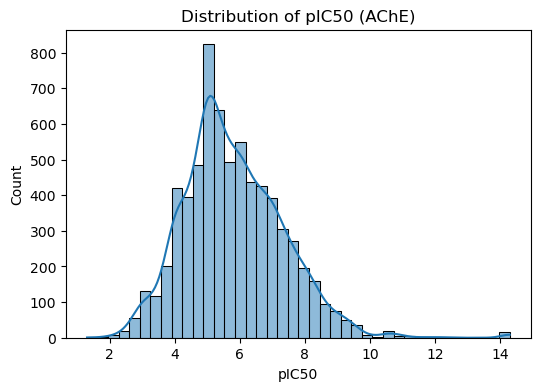

Example SMILES (first 10):


['Br.BrCC1CN=C(Nc2ccccn2)S1',
 'Br.CC[N+](CC)(CCCCCn1c(=O)cc(C)n(CCCCCCn2c(C)cc(=O)n(C)c2=O)c1=O)Cc1ccccc1[N+](=O)[O-]',
 'Br.CC[N+](CC)(CCCCCn1c(=O)cc(C)n(CCCCCn2c(C)cc(=O)n(C)c2=O)c1=O)Cc1ccccc1[N+](=O)[O-]',
 'Br.CC[N+](CC)(CCCCCn1c(=O)cc(C)n(CCCCn2c(C)cc(=O)n(C)c2=O)c1=O)Cc1ccccc1[N+](=O)[O-]',
 'Br.CC[N+](CC)(CCCCCn1c(=O)cc(C)n(CCCn2c(C)cc(=O)n(C)c2=O)c1=O)Cc1ccccc1[N+](=O)[O-]',
 'Br.COc1ccc2c3c1O[C@H]1C[C@@H](O)C=C[C@@]31CCN(C)C2',
 'Brc1ccc(-[n+]2ccc3ccccc3c2)cc1.[Br-]',
 'Brc1ccc(-c2nnc(N3CCN(c4ccccn4)CC3)o2)cc1',
 'Brc1ccc(-c2nnc(Nc3ncccn3)o2)cc1',
 'Brc1ccc(-c2nnc3sc(-c4ccoc4)nn23)cc1']

In [8]:
plt.figure(figsize=(6,4))
sns.histplot(df['pIC50'], bins=40, kde=True)
plt.title("Distribution of pIC50 (AChE)")
plt.xlabel("pIC50")
plt.show()

print("Example SMILES (first 10):")
df['canonical_smiles'].head(10).tolist()


In [9]:
# Compute RDKit features + Morgan fingerprints
nBits = 1024
rows = []
fps = []
bad_indices = []
for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    smi = row['canonical_smiles']
    mol = mol_from_smiles(smi)
    if mol is None:
        bad_indices.append(idx)
        continue
    descs = compute_descriptors(mol)
    fp = mol_to_fp_bits(mol, nBits=nBits, radius=2)
    fp_arr = np.array(fp)  # bit vector as array (0/1)
    # build row: descriptors + fp bits
    combined = {**descs}
    # name fingerprint columns as FP_0 ... FP_{nBits-1}
    for i,bit in enumerate(fp_arr):
        combined[f'FP_{i}'] = int(bit)
    rows.append(combined)
    fps.append(fp)

feat_df = pd.DataFrame(rows)
print("Feature matrix shape:", feat_df.shape)
# align df and feat_df: remove rows with failed molecules
df_clean = df.reset_index(drop=True).loc[[i for i in range(df.shape[0]) if i not in bad_indices]].reset_index(drop=True)
print("df_clean rows:", df_clean.shape)
features = feat_df.reset_index(drop=True)
features.shape


  0%|          | 0/6842 [00:00<?, ?it/s]

Feature matrix shape: (6842, 1032)
df_clean rows: (6842, 3)


(6842, 1032)

In [10]:
# Drop constant columns
n_unique = features.nunique()
const_cols = n_unique[n_unique <= 1].index.tolist()
print("Constant cols to drop:", len(const_cols))
features.drop(columns=const_cols, inplace=True)

# Remove highly correlated descriptor columns (for numeric descriptors only, not fingerprint bits)
# Identify descriptor columns (not FP_)
desc_cols = [c for c in features.columns if not c.startswith('FP_')]
# compute correlation matrix and drop one of any pair with corr>0.95
corr = features[desc_cols].corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print("Descriptor cols to drop due to high corr:", to_drop)
features.drop(columns=to_drop, inplace=True)

features.shape


Constant cols to drop: 0
Descriptor cols to drop due to high corr: ['NumValenceElectrons']


(6842, 1031)

In [11]:
X = features.values
y = df_clean['pIC50'].values

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, df_clean.index.values, test_size=0.20, random_state=42)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (5473, 1031) Test size: (1369, 1031)


In [12]:
pipe_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=1.0))
])
pipe_ridge.fit(X_train, y_train)
pred_ridge = pipe_ridge.predict(X_test)
print("Ridge test eval:", evaluate_regression(y_test, pred_ridge))


Ridge test eval: {'RMSE': 0.9972923533050354, 'MAE': 0.7358679740426353, 'R2': 0.600995602523956}


In [24]:
# Random Forest baseline (no scaling needed)
rf = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
print("RF test eval:", evaluate_regression(y_test, pred_rf))

# XGBoost
xgb = XGBRegressor(n_estimators=500, max_depth=6, learning_rate=0.05, random_state=42, n_jobs=-1)
xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)])
pred_xgb = xgb.predict(X_test)
print("XGB test eval:", evaluate_regression(y_test, pred_xgb))


RF test eval: {'RMSE': 0.9286135383870774, 'MAE': 0.6983075785196287, 'R2': 0.6540584508224074}
[0]	validation_0-rmse:1.54253
[1]	validation_0-rmse:1.50896
[2]	validation_0-rmse:1.47752
[3]	validation_0-rmse:1.44845
[4]	validation_0-rmse:1.42134
[5]	validation_0-rmse:1.39685
[6]	validation_0-rmse:1.37354
[7]	validation_0-rmse:1.35193
[8]	validation_0-rmse:1.33166
[9]	validation_0-rmse:1.30943
[10]	validation_0-rmse:1.29274
[11]	validation_0-rmse:1.27481
[12]	validation_0-rmse:1.25992
[13]	validation_0-rmse:1.24366
[14]	validation_0-rmse:1.22999
[15]	validation_0-rmse:1.21878
[16]	validation_0-rmse:1.20476
[17]	validation_0-rmse:1.19154
[18]	validation_0-rmse:1.17940
[19]	validation_0-rmse:1.16821
[20]	validation_0-rmse:1.15756
[21]	validation_0-rmse:1.14646
[22]	validation_0-rmse:1.13621
[23]	validation_0-rmse:1.12785
[24]	validation_0-rmse:1.11878
[25]	validation_0-rmse:1.11042
[26]	validation_0-rmse:1.10330
[27]	validation_0-rmse:1.09199
[28]	validation_0-rmse:1.08412
[29]	validation

[257]	validation_0-rmse:0.80118
[258]	validation_0-rmse:0.80084
[259]	validation_0-rmse:0.80056
[260]	validation_0-rmse:0.79997
[261]	validation_0-rmse:0.79930
[262]	validation_0-rmse:0.79898
[263]	validation_0-rmse:0.79860
[264]	validation_0-rmse:0.79840
[265]	validation_0-rmse:0.79815
[266]	validation_0-rmse:0.79769
[267]	validation_0-rmse:0.79764
[268]	validation_0-rmse:0.79727
[269]	validation_0-rmse:0.79708
[270]	validation_0-rmse:0.79694
[271]	validation_0-rmse:0.79680
[272]	validation_0-rmse:0.79667
[273]	validation_0-rmse:0.79626
[274]	validation_0-rmse:0.79594
[275]	validation_0-rmse:0.79576
[276]	validation_0-rmse:0.79570
[277]	validation_0-rmse:0.79563
[278]	validation_0-rmse:0.79559
[279]	validation_0-rmse:0.79554
[280]	validation_0-rmse:0.79527
[281]	validation_0-rmse:0.79494
[282]	validation_0-rmse:0.79488
[283]	validation_0-rmse:0.79458
[284]	validation_0-rmse:0.79443
[285]	validation_0-rmse:0.79426
[286]	validation_0-rmse:0.79397
[287]	validation_0-rmse:0.79362
[288]	va

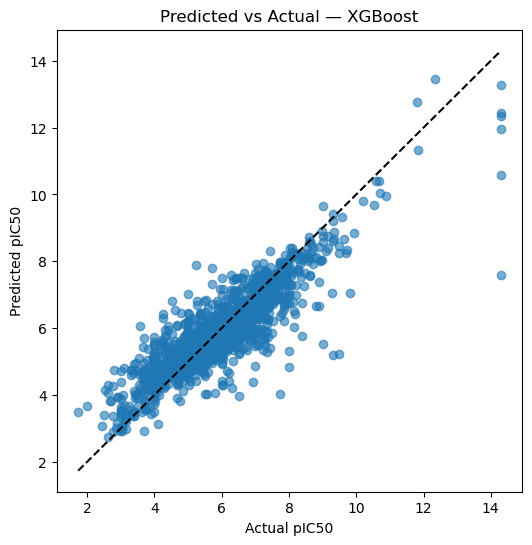

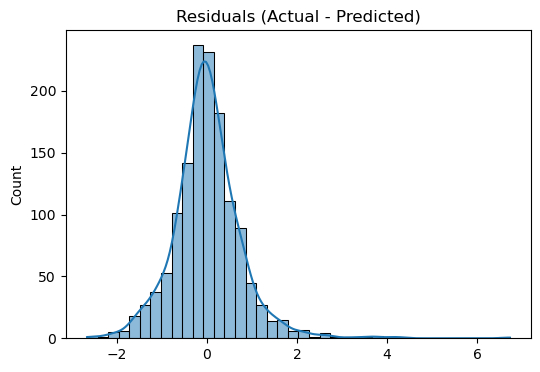

In [25]:
# Plot pred vs actual
best_pred = pred_xgb
plt.figure(figsize=(6,6))
plt.scatter(y_test, best_pred, alpha=0.6)
mn = min(min(y_test), min(best_pred))
mx = max(max(y_test), max(best_pred))
plt.plot([mn,mx],[mn,mx],'k--')
plt.xlabel("Actual pIC50")
plt.ylabel("Predicted pIC50")
plt.title("Predicted vs Actual — XGBoost")
plt.show()

# residuals
resid = y_test - best_pred
plt.figure(figsize=(6,4))
sns.histplot(resid, bins=40, kde=True)
plt.title("Residuals (Actual - Predicted)")
plt.show()


In [27]:
# from sklearn.model_selection import cross_val_score, KFold
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# scores = cross_val_score(xgb, X_train, y_train, scoring='neg_root_mean_squared_error', cv=kf, n_jobs=-1)
# print("XGB 5-fold CV RMSE (neg-root MSE returned):", -scores.mean(), "std:", scores.std())
from sklearn.model_selection import KFold
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []

for train_idx, val_idx in kf.split(X_train):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    
    model = XGBRegressor(n_estimators=500, max_depth=6, learning_rate=0.05, random_state=42, n_jobs=-1)
    model.fit(X_tr, y_tr)  # no early_stopping in 3.x
    
    preds = model.predict(X_val)
    rmse = np.sqrt(np.mean((y_val - preds)**2))
    rmse_scores.append(rmse)

print("XGB 5-fold CV RMSE:", np.mean(rmse_scores), "std:", np.std(rmse_scores))


XGB 5-fold CV RMSE: 0.792199453698134 std: 0.027031747971084253


In [28]:
# AD method 1: Tanimoto similarity to training set (Morgan fingerprints)
# Recreate RDKit fingerprint objects for training molecules
train_smiles = df_clean.loc[idx_train, 'canonical_smiles'].values
train_mols = [Chem.MolFromSmiles(s) for s in train_smiles]
train_fps = [AllChem.GetMorganFingerprintAsBitVect(m,2,nBits=nBits) for m in train_mols]

def max_tanimoto_similarity(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return 0.0
    fp = AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=nBits)
    sims = DataStructs.BulkTanimotoSimilarity(fp, train_fps)
    return max(sims) if len(sims)>0 else 0.0

# AD method 2: Mahalanobis distance in descriptor PCA space (we'll use descriptor-only columns)
from sklearn.decomposition import PCA
desc_columns = [c for c in features.columns if not c.startswith('FP_')]
desc_matrix = features[desc_columns].values
pca = PCA(n_components=min(10, desc_matrix.shape[1]))
pca.fit(desc_matrix[idx_train])  # fit on train
train_pca = pca.transform(desc_matrix[idx_train])
mean_vec = np.mean(train_pca, axis=0)
cov = np.cov(train_pca, rowvar=False)
inv_cov = np.linalg.pinv(cov)

def mahalanobis_distance(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.inf
    desc = compute_descriptors(mol)
    # build vector in same order as desc_columns
    v = np.array([desc.get(c, np.nan) for c in desc_columns], dtype=float)
    if np.any(np.isnan(v)):
        return np.inf
    v_pca = pca.transform([v])[0]
    diff = v_pca - mean_vec
    dist = np.sqrt(np.dot(np.dot(diff, inv_cov), diff.T))
    return float(dist)

# example usage for test set molecules
test_smiles = df_clean.loc[idx_test, 'canonical_smiles'].values
ad_info = []
for smi in test_smiles[:10]:
    ad_info.append((smi, max_tanimoto_similarity(smi), mahalanobis_distance(smi)))
ad_info[:5]


[('C#CCNC1CCc2c(OC(=O)N(C)C)cccc21.Cl',
  0.9772727272727273,
  1.1527646279484596),
 ('COC(=O)C1=C(Nc2ccccc2)C[C@@H](c2cccc([N+](=O)[O-])c2)N(c2ccccc2)[C@@H]1c1cccc([N+](=O)[O-])c1',
  0.6461538461538462,
  3.4797539816835803),
 ('Cl.Cl.N[C@@H](Cc1c[nH]c2ccccc12)C(=O)NCCCCNc1c2c(nc3cc(Cl)ccc13)CCCC2',
  1.0,
  3.143747568132786),
 ('CCN(CC)c1ccc(/C=C/c2ccc3ccccc3[n+]2C)c(OC)n1.[I-]',
  0.6428571428571429,
  2.653064582370598),
 ('COc1cccc(CNCCCCc2ccccc2)c1OCc1ccccc1',
  0.926829268292683,
  2.289854240788762)]

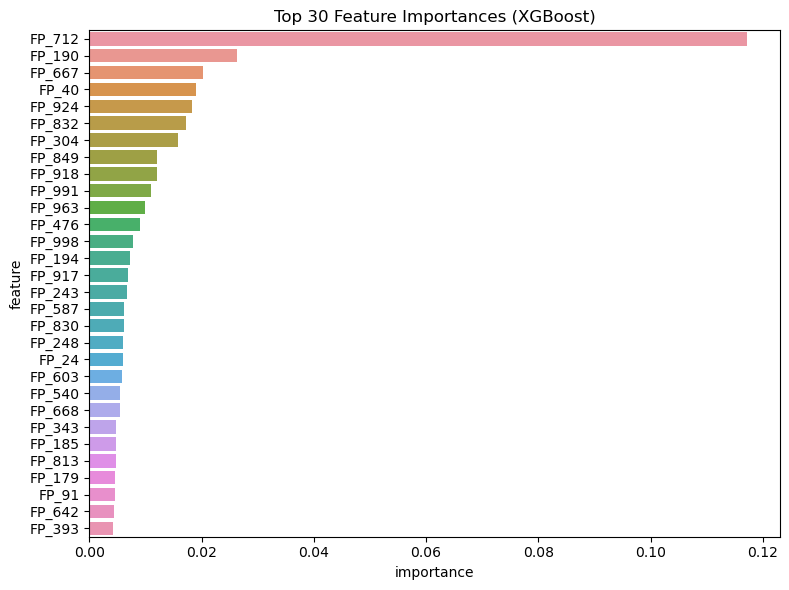

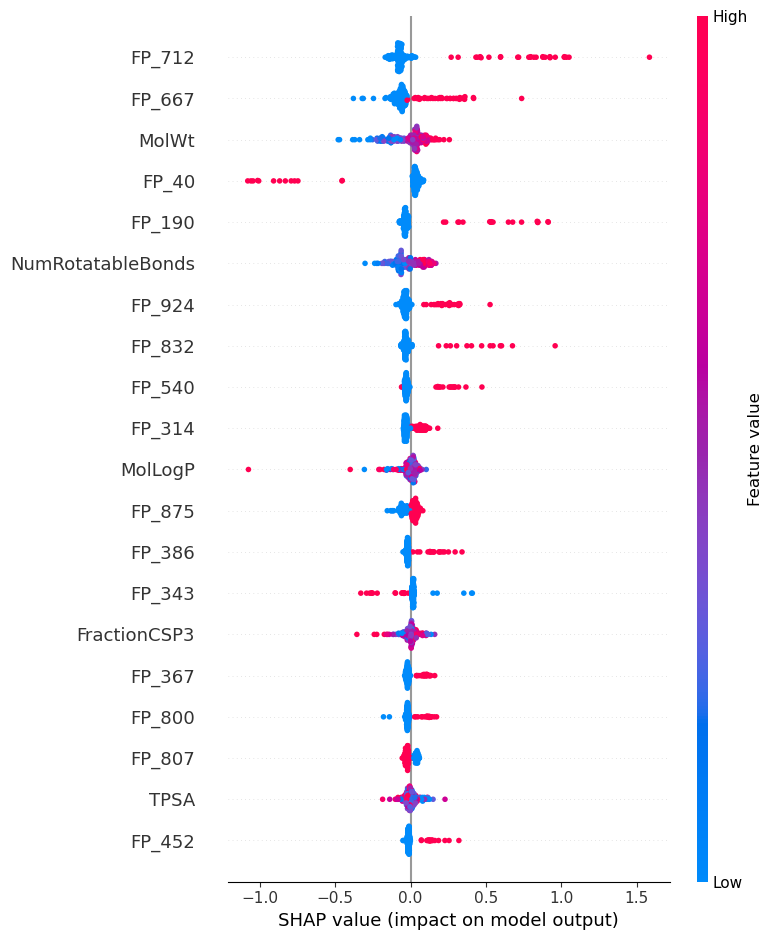

In [29]:
# Map feature importances back to column names
feature_names = features.columns.tolist()
importances = xgb.feature_importances_
# get top descriptor features (not fingerprint bits) for readability
importance_df = pd.DataFrame({'feature':feature_names, 'importance':importances})
importance_df_sorted = importance_df.sort_values('importance', ascending=False).head(30)
plt.figure(figsize=(8,6))
sns.barplot(y='feature', x='importance', data=importance_df_sorted)
plt.title("Top 30 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

# SHAP explanations on a sample of test
explainer = shap.TreeExplainer(xgb)
# use a sample to speed up
X_test_sample = X_test[:200]
# shap expects a matrix with same columns order; we pass pandas subset to keep names
X_test_df = pd.DataFrame(X_test_sample, columns=feature_names)
shap_values = explainer.shap_values(X_test_df)
shap.summary_plot(shap_values, X_test_df, show=True)


In [30]:
os.makedirs('models', exist_ok=True)
joblib.dump(xgb, 'models/qsar_xgb_acetylcholinesterase.joblib')
joblib.dump(feature_names, 'models/feature_names.joblib')
# Save PCA and AD thresholds if needed
joblib.dump(pca, 'models/descriptor_pca.joblib')
print("Saved model and artifacts in /models")


Saved model and artifacts in /models


In [31]:
%%bash
cat > app.py <<'PY'
import streamlit as st
import joblib
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors, rdMolDescriptors, DataStructs

# load objects
model = joblib.load('models/qsar_xgb_acetylcholinesterase.joblib')
feature_names = joblib.load('models/feature_names.joblib')
pca = joblib.load('models/descriptor_pca.joblib')

nBits = 1024

# helper functions (same as notebook)
def mol_from_smiles(smi):
    try:
        return Chem.MolFromSmiles(smi)
    except:
        return None

desc_columns = [c for c in feature_names if not c.startswith('FP_')]

def compute_descriptors_for_app(mol):
    # same desc names used in the notebook
    desc_names = ['MolLogP','MolWt','TPSA','NumHDonors','NumHAcceptors','NumRotatableBonds','FractionCSP3','NumValenceElectrons']
    dvals = []
    for name in desc_names:
        try:
            dvals.append(getattr(Descriptors, name)(mol))
        except:
            dvals.append(np.nan)
    return dvals

def make_feature_vector_from_smiles(smi):
    mol = mol_from_smiles(smi)
    if mol is None:
        return None
    # descriptors
    desc_vals = compute_descriptors_for_app(mol)
    # fingerprint
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=nBits)
    fp_arr = np.array(fp).astype(int)
    # build same-order vector as feature_names
    vec = []
    # descriptors (desc_columns order), but we used fixed desc order — keep consistency
    # Here we assume desc_columns matches the names used above; for safety, map names where possible
    for col in feature_names:
        if col.startswith('FP_'):
            idx = int(col.split('_')[1])
            vec.append(int(fp_arr[idx]))
        else:
            # map descriptor name to index in desc_vals list (based on known desc order)
            # this is a simplification — ensure descriptor names match notebook
            try:
                mapping = {
                    'MolLogP':0,'MolWt':1,'TPSA':2,'NumHDonors':3,'NumHAcceptors':4,'NumRotatableBonds':5,'FractionCSP3':6,'NumValenceElectrons':7
                }
                vec.append(float(desc_vals[mapping[col]]))
            except:
                vec.append(0.0)
    return np.array(vec)

st.title("QSAR — AChE pIC50 predictor")
smi = st.text_input("Enter SMILES")
if st.button("Predict"):
    vec = make_feature_vector_from_smiles(smi)
    if vec is None:
        st.error("Invalid SMILES")
    else:
        pred = model.predict([vec])[0]
        st.success(f"Predicted pIC50: {pred:.2f}")
        mol = Chem.MolFromSmiles(smi)
        st.image(Draw.MolToImage(mol))
PY
echo "app.py written"


app.py written
